In [2]:
import voltron 
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd
import pickle as pkl
import numpy as np

import datetime
import gpytorch
from botorch.models import SingleTaskGP
from botorch.optim.fit import fit_gpytorch_torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.means import ConstantMean, LinearMean, Mean
from gpytorch.kernels import SpectralMixtureKernel, MaternKernel, RBFKernel, ScaleKernel
from voltron.train_utils import LearnGPCV, TrainVolModel, TrainVoltMagpieModel, TrainBasicModel
from voltron.models import VoltMagpie
from voltron.means import LogLinearMean, EWMAMean

from voltron.rollout_utils import GeneratePrediction, Rollouts
from voltron.data import make_ticker_list, DataGetter, GetStockHistory


Warning no robinhood utils.


In [3]:
from gpytorch.kernels import RBFKernel, IndexKernel, RQKernel
from gpytorch.lazy import InterpolatedLazyTensor, lazify
from gpytorch.utils.broadcasting import _mul_broadcast_shape

class IndexRBFKernel(RBFKernel):
    def __init__(self, task_locs, *args, **kwargs):
        self.task_locs = task_locs
        super().__init__(*args, **kwargs)
        
    def _eval_covar_matrix(self):
        distmat = torch.acos((nvector.unsqueeze(-2) * nvector.unsqueeze(-3)).sum(-1) - 1e-6)
        dist = (distmat.mul(-1) / self.lengthscale).exp()
        return lazify(dist).add_jitter(1e-3)
        # return lazify(super().forward(self.task_locs, self.task_locs)).add_jitter(1e-5)
    
    @property
    def covar_matrix(self):
        return self._eval_covar_matrix()
    
    def forward(self, i1, i2):
        i1, i2 = i1.long(), i2.long()
        covar_matrix = self._eval_covar_matrix()
        batch_shape = _mul_broadcast_shape(i1.shape[:-2], i2.shape[:-2], self.batch_shape)

        res = InterpolatedLazyTensor(
            base_lazy_tensor=covar_matrix,
            left_interp_indices=i1.expand(batch_shape + i1.shape[-2:]),
            right_interp_indices=i2.expand(batch_shape + i2.shape[-2:]),
        )
        return res

In [4]:
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from voltron.models import MultitaskVariationalGP
from gpytorch.priors import LKJCovariancePrior, SmoothedBoxPrior
from voltron.models import MultitaskBMGP
from voltron.means import LogLinearMean
from gpytorch.likelihoods import MultitaskGaussianLikelihood

def get_and_fit_volmodel(site_locs, train_x, pred_scale, train_iter=200,
                        printing=False):
    prior = LKJCovariancePrior(eta=5.0, n=pred_scale.shape[-1], sd_prior=SmoothedBoxPrior(0.05, 1.0))

    vol_lh = MultitaskGaussianLikelihood(num_tasks=pred_scale.shape[-1])
    vol_lh.noise.data = torch.tensor([1e-6])
    vol_model = MultitaskBMGP(
        train_x, pred_scale.log(), vol_lh, task_covar_prior=prior, # base_mean=LogLinearMean(1)
    )
    vol_model.covar_module.task_covar_module = IndexRBFKernel(site_locs)
    vol_model.covar_module.task_covar_module.lengthscale = 0.01
    vol_model = vol_model.to(train_x.device)

    optimizer = torch.optim.Adam([
        {'params': vol_model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(vol_lh, vol_model)

    for i in range(train_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = vol_model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, pred_scale.log())
        loss.backward()
        if printing:
            if i % 50 == 0:
                print(loss.item(), vol_model.covar_module.data_covar_module.vol.item())
        optimizer.step()
        
    
    return vol_model, vol_lh

def get_and_fit_mtgpcv(site_locs, train_x, log_returns, train_iter=200, printing=False):
    likelihood = VolatilityGaussianLikelihood(batch_shape=[log_returns.shape[0]], param="exp")
    dt = train_x[1] - train_x[0]
    # corresponds to ICM
    model = MultitaskVariationalGP(
        inducing_points=train_x, 
        covar_module=BMKernel().to(train_x.device), learn_inducing_locations=False,
        num_tasks = log_returns.shape[0], 
        prior=LKJCovariancePrior(eta=5.0, n=log_returns.shape[0], sd_prior=SmoothedBoxPrior(0.05, 1.0))
    )
    model.index_kernel = IndexRBFKernel(site_locs).to(train_x.device)
    model.index_kernel.lengthscale = 0.01

    model = model.to(train_x.device)
    model.initialize_variational_parameters(likelihood=likelihood, x=train_x, y=log_returns.t())
    
    model = model.to(train_x.device)
    likelihood = likelihood.to(train_x.device)


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {"params": model.parameters()}, 
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    # num_data refers to the number of training datapoints
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_x.shape[0])
    
    batched_train_x = train_x#[:-1]
    
    print_every = 50
    for i in range(train_iter):
        # Zero backpropped gradients from previous iteration
        optimizer.zero_grad()
        # Get predictive output
        output = model(batched_train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, log_returns.t()) / model.num_tasks
        loss.backward()
        if printing:
            if i % print_every == 0:
                print('Iter %d/%d - Loss: %.3f' % (i + 1, train_iter, loss.item()))
        optimizer.step()
        
    model.eval();
    likelihood.eval();
    predictive = model(train_x)
    # pred_scale = likelihood(predictive).scale.mean(0).detach()
    samples = likelihood(predictive).scale.detach()
    return samples.mean(0) / dt**0.5, model


def get_and_fit_datamods(train_x, train_y, vols, vmod, vlh,
                         train_iter=200, printing=False, k=200, mean_func='ewma'):
    model_list = []
    nmodel = vols.shape[-1]
    for mdl_idx in range(nmodel):
        mod = TrainVoltMagpieModel2(train_x, train_y[mdl_idx, :], vmod, vlh, vols[:, mdl_idx],
                                  train_iters=train_iter, k=k, mean_func=mean_func)
        model_list.append(mod)
        
    return model_list
    

def TrainVoltMagpieModel2(train_x, train_y, vol_model, vol_lh, vol_path,
                   train_iters=1000, printing=False, k=25,
                        mean_func="ewma"):
    
    voltron_lh = gpytorch.likelihoods.GaussianLikelihood().to(train_x.device)
    voltron = VoltMagpie(train_x, train_y.log(),
                             voltron_lh, vol_path, k=k).to(train_x.device)
    
    if mean_func.lower() in ["ewma", "dewma", "tewma", "meanrevert"]:
        # default voltmagpie is an ewma mean so we don't need to redefine anything
        grad_flags = [True, False, False, False]
        
        if mean_func.lower() == "dewma":
            voltron.mean_module = DEWMAMean(train_x, train_y.log(), k).to(train_x.device)
        elif mean_func.lower() == 'tewma':
            voltron.mean_module = TEWMAMean(train_x, train_y.log(), k).to(train_x.device)
            
    elif mean_func.lower()=='constant':
        voltron.mean_module = gpytorch.means.ConstantMean().to(train_x.device)
        grad_flags = [True, True, False, False, False]
    elif mean_func.lower()=='loglinear':
        voltron.mean_module = LogLinearMean(1).to(train_x.device)
        voltron.mean_module.initialize_from_data(train_x, train_y.log())
        grad_flags = [True, True, True, False, False, False]
    elif mean_func.lower()=='linear':
        voltron.mean_module = gpytorch.means.LinearMean(1).to(train_x.device)
        grad_flags = [True, True, True, False, False, False]

    voltron.likelihood.raw_noise.data = torch.tensor([1e-5]).to(train_x.device)
#     voltron.vol_lh = vol_lh.to(train_x.device)
#     voltron.vol_model = vol_model.to(train_x.device)
    del voltron.vol_model, voltron.vol_lh
    
    for idx, p in enumerate(voltron.parameters()):
        p.requires_grad = grad_flags[idx]

    voltron.train();
    voltron_lh.train();
#     voltron.vol_lh.train();
#     voltron.vol_model.train();

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': voltron.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(voltron_lh, voltron)

    print_every = 50
    for i in range(train_iters):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = voltron(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y.log())
        loss.backward()
        if printing:
            if i % print_every == 0:
                print('Iter %d/%d - Loss: %.3f' % (i + 1, train_iters, loss.item()))
        optimizer.step()
        
        
    return voltron, voltron_lh

## Load In, Set Up Data

In [5]:
stn_names, stn_lonlat, stn_data = pkl.load(open("./wind_data.p", 'rb'))

In [6]:
lonlat = np.array(list(stn_lonlat.values()))
full_dat = np.stack(list(stn_data.values()), -1).T
full_dat[full_dat == -99.0] = 0.
names = np.array(list(stn_names.values()))

keep_idx = np.where(full_dat[..., :1000].mean(1) > 1.)[0]
lonlat = lonlat[keep_idx]
full_dat = full_dat[keep_idx]
names = names[keep_idx]

In [7]:
np.argmax(full_dat.max(1))

59

In [8]:
lonlat[64]

array([-106.89,   34.36])

In [9]:
names[64]

'NM_Socorro_20_N'

## subset just for testing

In [10]:
lon_keepers = np.logical_and(lonlat[:, 0] > -90, lonlat[:, 0] < -60)
lat_keepers = np.logical_and(lonlat[:, 1] < 50, lonlat[:, 1] > 25)
# lon_keepers = lonlat[:, 0] < -125
# lat_keepers = lonlat[:, 1] > 50
keepers = np.where(np.logical_and(lon_keepers, lat_keepers))[0]

In [11]:
names[keepers]

array(['AL_Fairhope_3_NE', 'AL_Gadsden_19_N', 'AL_Selma_13_WNW',
       'FL_Sebring_23_SSE', 'FL_Titusville_7_E', 'GA_Brunswick_23_S',
       'GA_Newton_11_SW', 'GA_Watkinsville_5_SSE', 'IL_Champaign_9_SW',
       'IN_Bedford_5_WNW', 'KY_Versailles_3_NNW', 'ME_Old_Town_2_W',
       'MI_Chatham_1_SE', 'MI_Gaylord_9_SSW', 'MS_Holly_Springs_4_N',
       'NC_Asheville_13_S', 'NC_Durham_11_W', 'NH_Durham_2_N',
       'NH_Durham_2_SSW', 'NY_Ithaca_13_E', 'OH_Wooster_3_SSE',
       'ON_Egbert_1_W', 'PA_Avondale_2_N', 'RI_Kingston_1_NW',
       'RI_Kingston_1_W', 'SC_Blackville_3_W', 'TN_Crossville_7_NW',
       'VA_Cape_Charles_5_ENE', 'VA_Charlottesville_2_SSE',
       'WV_Elkins_21_ENE'], dtype='<U34')

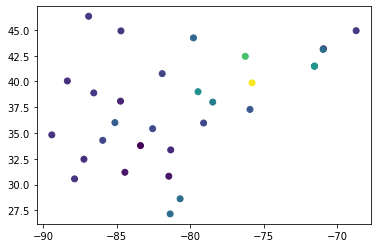

In [12]:
plt.scatter(lonlat[keepers, 0], lonlat[keepers, 1], c=full_dat[keepers, 500])

In [13]:
full_dat[keepers].shape

(30, 105120)

## Train 

In [14]:
0.65 * 105120

68328.0

In [15]:
ntrain = 500
ntest = 100
start = 70000
xrange = torch.arange(start, 4 * (ntrain + ntest + 1) + start, 4)

In [16]:
scale = 365 #* 8

In [17]:

train_x = torch.arange(ntrain).type(torch.FloatTensor).cuda() / scale + 1./scale
test_x = torch.arange(ntrain, ntrain + ntest).type(torch.FloatTensor).cuda() /scale + 1./scale


train_y = torch.FloatTensor(full_dat[keepers][:,xrange[:ntrain+1]]).cuda() + 1
test_y = torch.FloatTensor(full_dat[keepers][:,xrange[(ntrain):(ntrain + ntest)]]).cuda() + 1

returns = torch.log(train_y[:, 1:]/train_y[:, :-1])

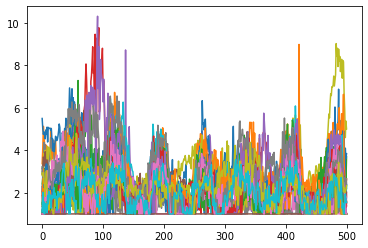

In [18]:
plt.plot(train_y.cpu().t())

In [19]:
sites = (torch.tensor(lonlat[keepers]))

# convert first to radians and then to n-vector rep
sites = sites * np.pi / 180
sines, coses = torch.sin(sites), torch.cos(sites)
nvector = torch.stack((coses.prod(dim=1), coses[..., 0] * sines[..., 1], sines[..., 0])).T.float().cuda()

In [20]:
%pdb

Automatic pdb calling has been turned ON


In [21]:
vol, model = get_and_fit_mtgpcv(nvector, train_x, returns, printing=True, train_iter=200)

/home/wesley_m/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iter 1/200 - Loss: 80.042


/home/wesley_m/gpytorch/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/wesley_m/gpytorch/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/home/wesley_m/gpytorch/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


Iter 51/200 - Loss: 48.336
Iter 101/200 - Loss: 44.116
Iter 151/200 - Loss: 42.610


/home/wesley_m/gpytorch/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


In [22]:
model.data_kernel.vol

tensor([0.1988], device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
vmod, vlh = get_and_fit_volmodel(nvector, train_x, vol, printing=True, train_iter=200)

1.1960381269454956 0.20000000298023224
1.0135403871536255 0.2891941964626312
0.8152499794960022 0.3904932737350464
0.6048607230186462 0.4938216805458069


In [24]:
vmod.covar_module.task_covar_module.covar_matrix.diag()

tensor([0.9360, 0.9360, 0.9360, 0.9398, 0.9360, 0.9360, 0.9360, 0.9360, 0.9360,
        0.9360, 0.9342, 0.9360, 0.9360, 0.9342, 0.9360, 0.9360, 0.9342, 0.9360,
        0.9360, 0.9360, 0.9360, 0.9342, 0.9342, 0.9360, 0.9360, 0.9360, 0.9360,
        0.9360, 0.9360, 0.9360], device='cuda:0', grad_fn=<AddBackward0>)

In [25]:
vmod.covar_module.data_covar_module.vol # * vmod.covar_module.task_covar_module.covar_matrix.diag()

tensor([0.5857], device='cuda:0', grad_fn=<AddBackward0>)

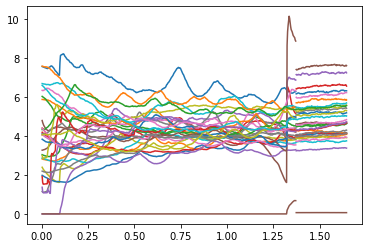

In [26]:
plt.plot(train_x.cpu(), vol.cpu())
plt.plot(test_x.cpu(), vmod.posterior(test_x).sample(torch.Size((256,))).exp().mean(0).cpu())

In [27]:
nsample = 5
# nmodel = len(model_list)
vmod.eval()
pred_vol = vmod.posterior(test_x).sample(torch.Size((nsample,))).exp()

In [28]:
model_list = get_and_fit_datamods(train_x, train_y[:, 1:], vol, vmod, vlh,
                                 train_iter=200)

## Simulate

In [29]:
from gpytorch.utils.cholesky import psd_safe_cholesky

def GeneratePrediction(train_x, train_y, test_x, pred_vol, model, latent_mean=None, theta=0.5):
    vol = model.log_vol_path.exp()
    if model.train_x.ndim != test_x.ndim:
        test_x_for_stack = test_x.unsqueeze(0).repeat(model.train_x.shape[0], 1)
    else:
        test_x_for_stack = test_x
    if vol.ndim == 1:
        vol_for_stack = vol.unsqueeze(0).repeat(pred_vol.shape[0], 1)
    else:
        vol_for_stack = vol

    full_x = torch.cat((model.train_x, test_x_for_stack),dim=-1)
    # print("vol stack = ", vol_for_stack.shape)
    # print("pred_vol = ", pred_vol.shape)
    full_vol = torch.cat((vol_for_stack, pred_vol),dim=-1)

    test_x.repeat(2, test_x.numel())

    idx_cut = model.train_x.shape[-1]
    
    cov_mat = model.covar_module(full_x.unsqueeze(-1), full_vol.unsqueeze(-1)).evaluate()
    K_tr = cov_mat[..., :idx_cut, :idx_cut]
    K_tr_te = cov_mat[..., :idx_cut, idx_cut:]
    K_te = cov_mat[..., idx_cut:, idx_cut:]

    train_mean = model.mean_module(model.train_x)
    train_diffs = model.train_y.unsqueeze(-1) - train_mean.unsqueeze(-1)
    # use psd cholesky if you must evaluate
    K_tr_chol = psd_safe_cholesky(K_tr, jitter=1e-4)
    pred_mean = K_tr_te.transpose(-1, -2).matmul(torch.cholesky_solve(train_diffs, K_tr_chol))
    # print(voltron.mean_module(test_x).detach().T.shape)
    # print(pred_mean.shape)
    pred_mean += model.mean_module(test_x).detach().T.unsqueeze(-1)
    if latent_mean is not None:
        pred_mean -= theta * (pred_mean - latent_mean)

    pred_cov = K_te - K_tr_te.transpose(-1, -2).matmul(torch.cholesky_solve(K_tr_te, K_tr_chol))

    pred_cov = pred_cov.clamp(min=0.)
    pred_cov_L = psd_safe_cholesky(pred_cov, jitter=1e-4)
    samples = torch.randn(*cov_mat.shape[:-2], test_x.shape[0], 1).to(test_x.device)
    samples = pred_cov_L @ samples

    if pred_mean.ndim == 1:
        return samples + pred_mean.unsqueeze(-1)
    else:
        return (samples + pred_mean).squeeze(-1)    

In [30]:
%pdb

Automatic pdb calling has been turned OFF


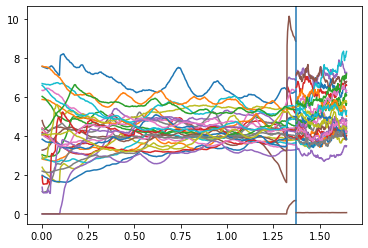

In [31]:
plt.plot(train_x.cpu(), vol.cpu())
plt.axvline(train_x[-1].cpu())
plt.plot(test_x.cpu(), pred_vol.mean(0).cpu())

In [32]:
nmodel = len(model_list)

In [33]:
theta = 0.1

ntest = test_x.numel()
samples = torch.zeros(nsample, ntest, nmodel)
for mdl_idx, (model, lh) in enumerate(model_list):
    latent_mean = train_y.log()[mdl_idx, :].mean()
    samples[:, 0, mdl_idx] = GeneratePrediction(train_x, train_y[mdl_idx, :], 
                                       test_x[0].unsqueeze(0), 
                                       pred_vol[:, 0, mdl_idx].unsqueeze(1),
                                      model, latent_mean=latent_mean, theta=theta).squeeze()
    train_stack_y = train_y[mdl_idx, 1:].log().repeat(nsample, 1)
    train_stack_vol = model.log_vol_path.repeat(nsample, 1)

    for idx in range(1, ntest):
        stack_y = torch.cat((train_stack_y, 
                             samples[:, :idx, mdl_idx].to(train_stack_y.device)), -1)
        stack_vol = torch.cat((train_stack_vol, 
                               pred_vol[:, :idx, mdl_idx].to(train_stack_vol.device)), -1)
        
        rolling_x = torch.cat((train_x, test_x[:idx]))
        model.mean_module.train_y = stack_y
        model.mean_module.train_x = rolling_x

        model.train_x = rolling_x
        model.train_y = stack_y
        model.log_vol_path = stack_vol
        samples[:, idx, mdl_idx] = GeneratePrediction(train_x, train_y[mdl_idx, :], 
                                             test_x[idx].unsqueeze(0), 
                                           pred_vol[:, idx, mdl_idx].unsqueeze(-1),
                                            model, latent_mean=latent_mean, theta=theta).squeeze()



/home/wesley_m/gpytorch/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


In [34]:
train_y.shape

torch.Size([30, 501])

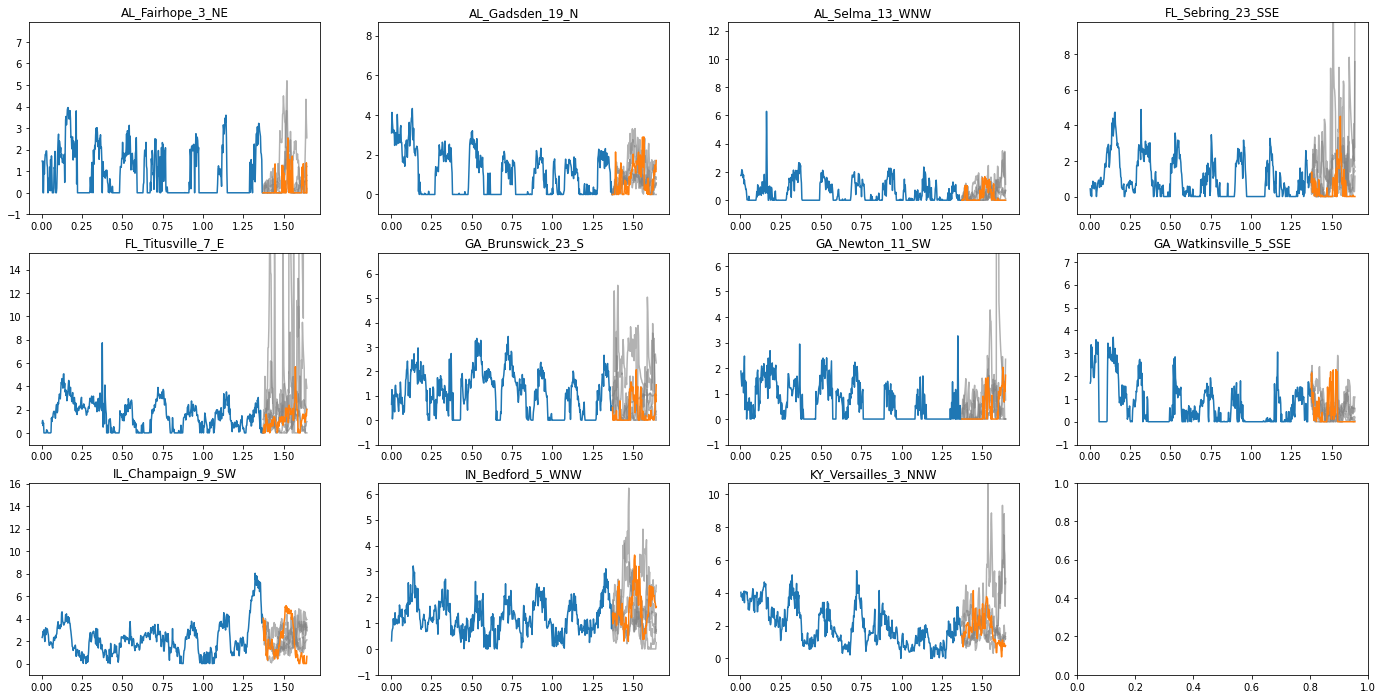

In [35]:
fig, ax = plt.subplots(3, 4, figsize = (24, 12))
ax = ax.reshape(-1)

for i in range(11):
    ax[i].plot(train_x.cpu(), train_y[i, 1:].cpu()-1)
    ax[i].plot(test_x.cpu(), test_y[i, :].cpu() - 1, zorder=10)
    ax[i].plot(test_x.cpu(), (samples[..., i].cpu().T.exp()-1).clamp(min=0.), color='gray', alpha = 0.6)
    ax[i].set_ylim(-1, 2.0 * (train_y[i].max().item() - 1))
    ax[i].set_title(names[keepers][i])

(0.0, 10.0)

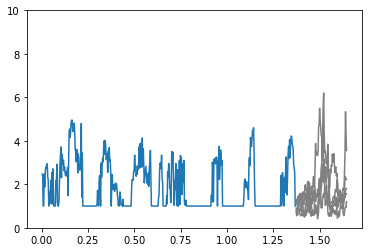

In [36]:
stn_idx = 0
plt.plot(train_x.cpu(), train_y[stn_idx, 1:].cpu())
plt.plot(test_x.cpu(), samples[..., stn_idx].cpu().T.exp(), color='gray')
plt.ylim(0, 10)

In [37]:
est_covar = vmod.covar_module.task_covar_module.covar_matrix.evaluate().cpu().detach()
inv_root_diag = torch.diag(est_covar.diag().pow(-0.5))
est_corr = inv_root_diag.matmul(est_covar).matmul(inv_root_diag)

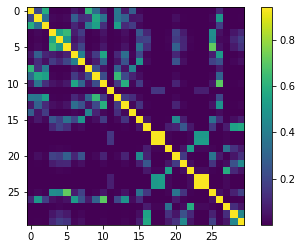

In [38]:
f = plt.imshow(est_covar)
plt.colorbar(f)

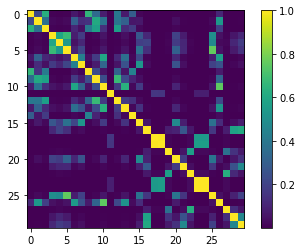

In [39]:
f = plt.imshow(est_corr)
plt.colorbar(f)

In [41]:
lonlats = torch.tensor(lonlat[keepers])
covars = est_covar[14]

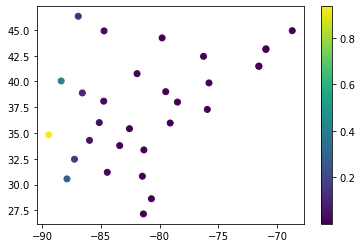

In [46]:
f = plt.scatter(*lonlats.t(), c=covars)
plt.colorbar(f)
plt.xlabel("")

In [47]:
torch.save({"lonlats": lonlats, "covar": covars}, f="covars_for_plots.pt")